Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

In [2]:
import pandas as pd
import pickle
import numpy as np
import re
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import os
import warnings
warnings.filterwarnings('ignore') 


In [3]:
train=pd.read_csv('train.csv', parse_dates=['datetime'])
test=pd.read_csv('test.csv', parse_dates=['datetime'])

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
train.shape,test.shape

((10886, 12), (6493, 9))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [11]:
!pip install pandas_profiling

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'c:\\users\\2211444\\anaconda3\\scripts\\tqdm.exe'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ------------------------------------ 324.4/324.4 kB 628.2 kB/s eta 0:00:00
     ------------------------------------ 345.9/345.9 kB 858.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 9.2/9.2 MB 9.8 MB/s eta 0:00:00
     ---------------------------------------- 11.0/11.0 MB 9.2 MB/s eta 0:00:00
     ------------------------------------ 296.5/296.5 kB 554.9 kB/s eta 0:00:00
     ------------------------------------ 102.7/102.7 kB 179.5 kB/s eta 0:00:00
     -------------------------------------- 663.3/663.3 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 78.5/78.5 kB 124.7 kB/s eta 0:00:00
     ---------------------------------------- 4.7/4.7 MB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 39.8/39.8 MB 4.3 MB/s eta 0:00:00
     ------------------------------------ 233.8/233.8 kB 397.9 kB/s eta 0:00:00
  Created wheel for h

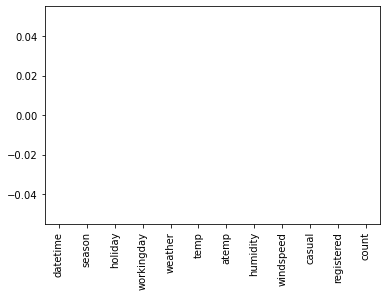

In [15]:
train.isna().sum().plot(kind='bar')

1. no null values  present in the training dataset

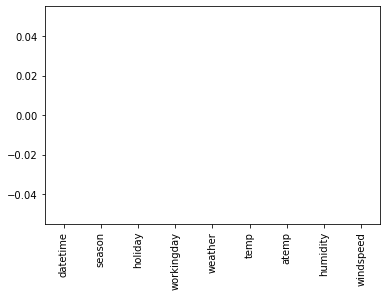

  Using cached pandas_profiling-3.6.6-py2.py3-none-any.whl (324 kB)
  Using cached ydata_profiling-4.1.2-py2.py3-none-any.whl (345 kB)
  Using cached pandas-1.5.3-cp38-cp38-win_amd64.whl (11.0 MB)
  Using cached visions-0.7.5-py3-none-any.whl (102 kB)
  Using cached multimethod-1.9.1-py3-none-any.whl (10 kB)
  Using cached ImageHash-4.3.1-py2.py3-none-any.whl (296 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached phik-0.12.3-cp38-cp38-win_amd64.whl (663 kB)
  Using cached statsmodels-0.13.5-cp38-cp38-win_amd64.whl (9.2 MB)
  Using cached tangled_up_in_unicode-0.2.0-py3-none-any.whl (4.7 MB)
  Using cached scipy-1.9.3-cp38-cp38-win_amd64.whl (39.8 MB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.0
    Uninstalling scipy-1.5.0:
      Successfully uninstalled scipy-1.5.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\2211444\\Anaconda3\\Lib\\site-packages\\~cipy\\sparse\\_sparsetools.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
test.isna().sum().plot(kind='bar')

1. No null values present in the test set

In [19]:
def convert_date(df):
    
    
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek
    df["day"]=df["datetime"].dt.day
    df["year"]=df["datetime"].dt.year
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['month_start'] = df['datetime'].dt.is_month_start
    
    
    return df

In [20]:
data=convert_date(train)

In [21]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,weekday,day,year,dayofweek,month_start
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,5,1,2011,5,True
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,5,1,2011,5,True
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,5,1,2011,5,True
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,5,1,2011,5,True
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,5,1,2011,5,True


In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [23]:
col_names=list(data.columns)
for index,col_name in enumerate(col_names):
    print(index ," :" ,col_name)

0  : datetime
1  : season
2  : holiday
3  : workingday
4  : weather
5  : temp
6  : atemp
7  : humidity
8  : windspeed
9  : casual
10  : registered
11  : count
12  : month
13  : hour
14  : weekday
15  : day
16  : year
17  : dayofweek
18  : month_start


In [24]:
data=data.rename(columns={col_names[5]: "Temperature(C)",col_names[6]:"Dew Temperature(C)",col_names[7]: "humidity(%)",
                          col_names[8]:"Wind Speed(m/s)",col_names[9]:"Number of rented bikes"
              })

In [25]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather',
       'Temperature(C)', 'Dew Temperature(C)', 'humidity(%)',
       'Wind Speed(m/s)', 'Number of rented bikes', 'registered', 'count',
       'month', 'hour', 'weekday', 'day', 'year', 'dayofweek', 'month_start'],
      dtype='object')

In [26]:
data['season'].value_counts()

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

Text(0.5, 1.0, 'Box plot on Count Across dayofweek')

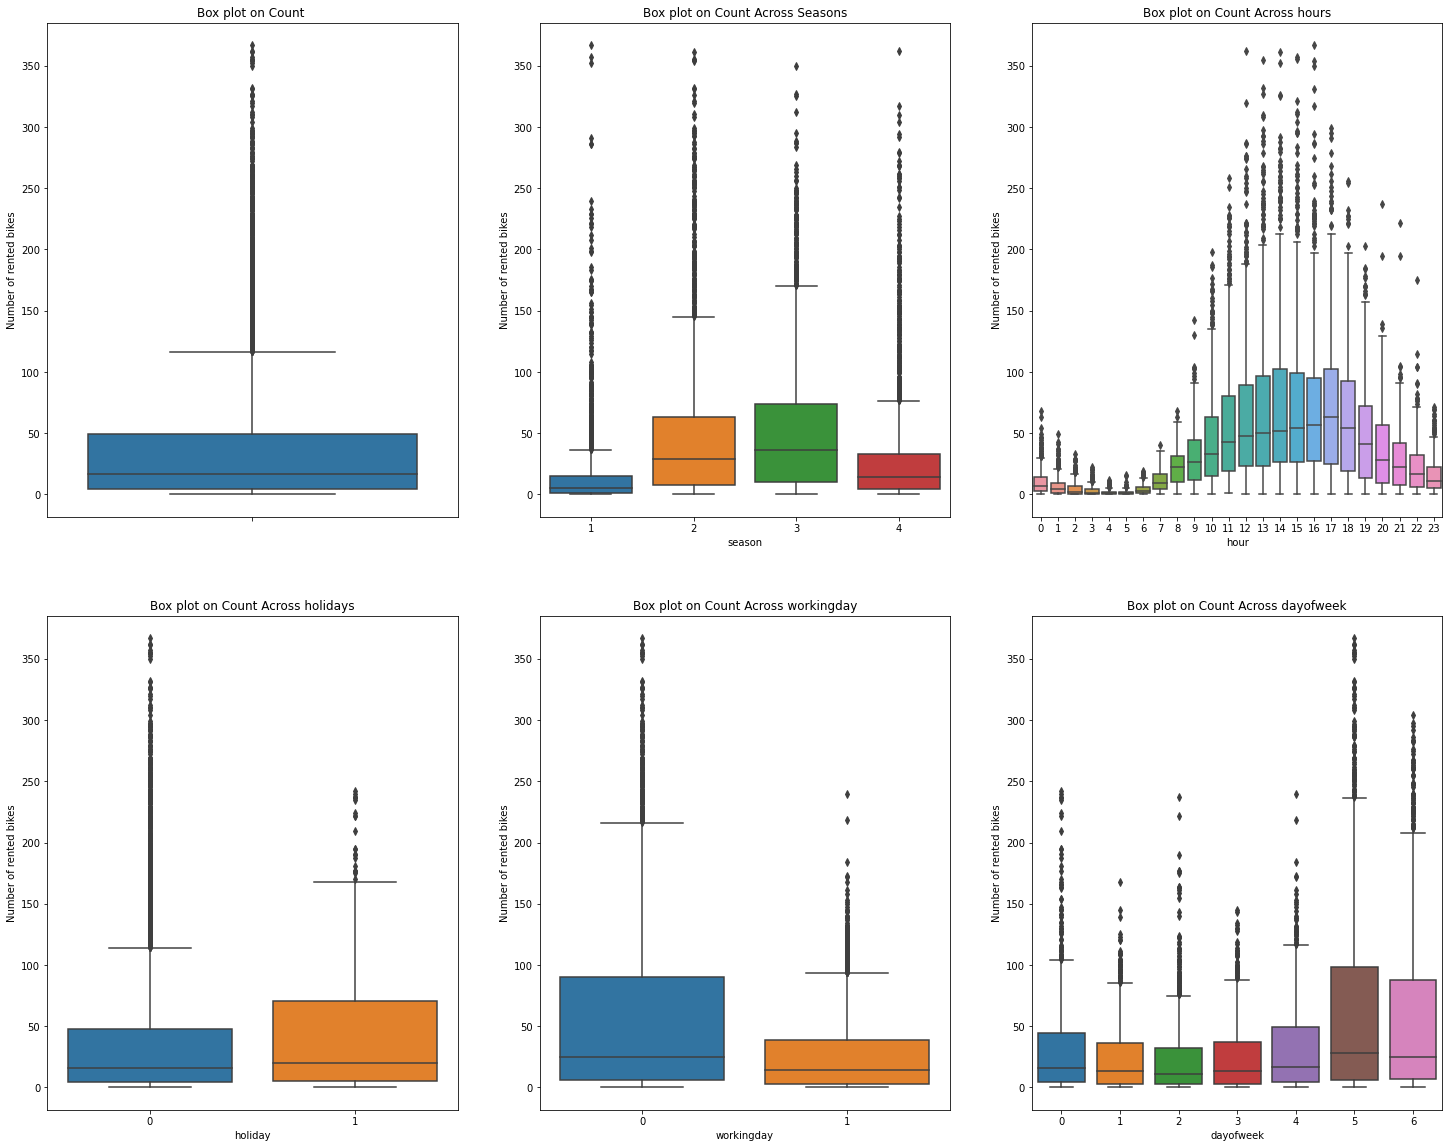

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(25, 20))
sns.boxplot(y=data["Number of rented bikes"],ax=ax[0][0])
ax[0][0].set_title("Box plot on Count ")

# sns.boxplot(x='season',y=data"Number of rented bikes",data = data,ax=ax[0][1])
# ax[0][1].set_title("Box plot on Count across seasons ")

sns.boxplot(x="season",y="Number of rented bikes",data=data,ax=ax[0][1])
ax[0][1].set_title("Box plot on Count Across Seasons")

sns.boxplot(x="hour",y="Number of rented bikes",data=data,ax=ax[0][2])
ax[0][2].set_title("Box plot on Count Across hours")


sns.boxplot(x="holiday",y="Number of rented bikes",data=data,ax=ax[1][0])
ax[1][0].set_title("Box plot on Count Across holidays")

sns.boxplot(x="workingday",y="Number of rented bikes",data=data,ax=ax[1][1])
ax[1][1].set_title("Box plot on Count Across workingday")

sns.boxplot(x="dayofweek",y="Number of rented bikes",data=data,ax=ax[1][2])
ax[1][2].set_title("Box plot on Count Across dayofweek")

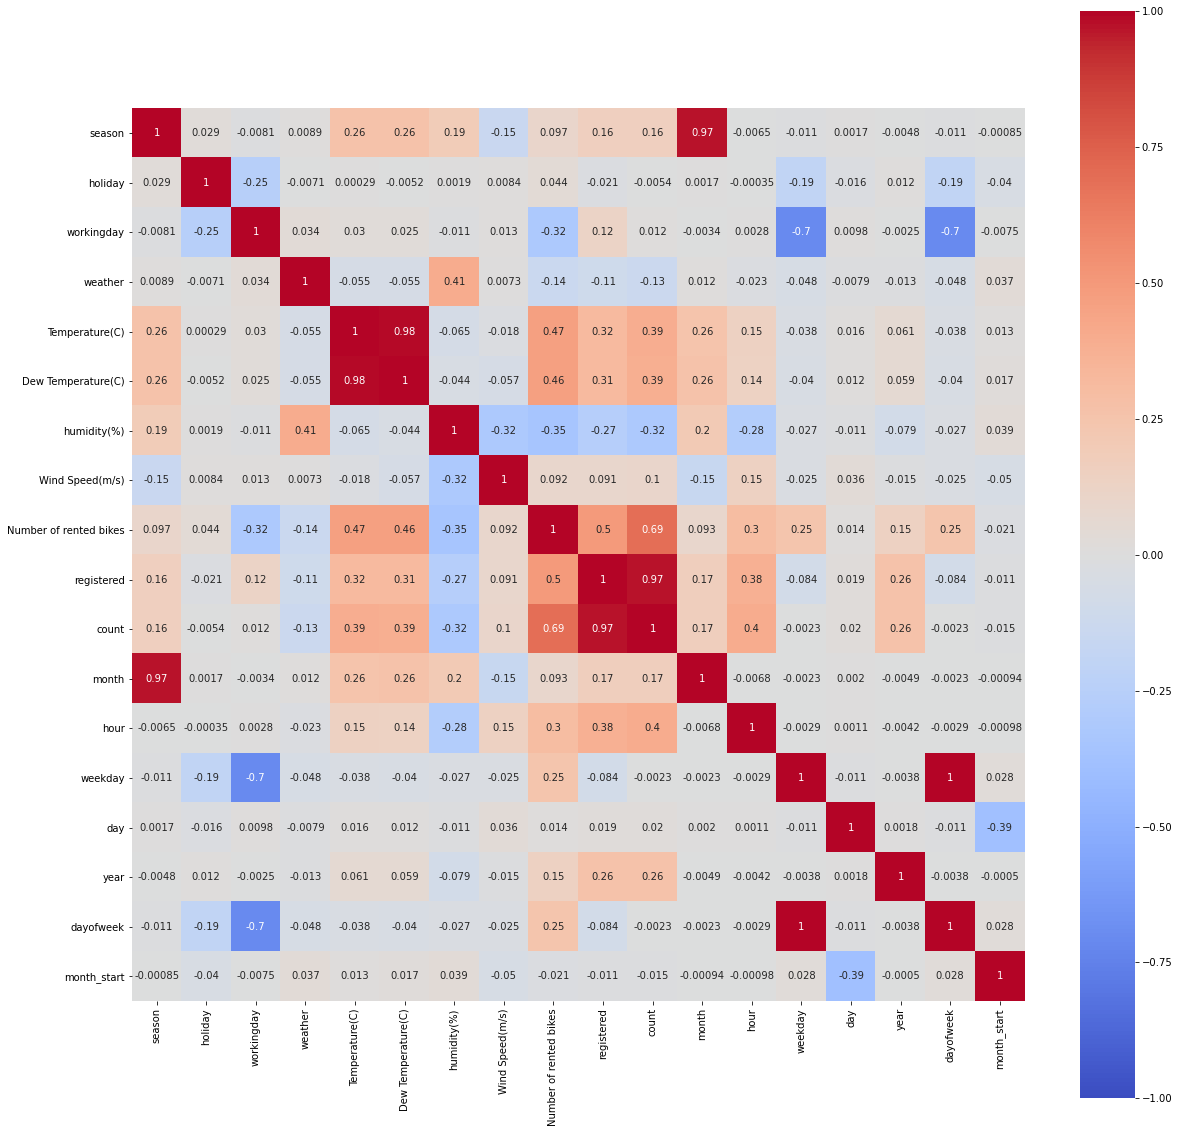

In [28]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True)

In [29]:
df1corr = pd.DataFrame(data.corr().unstack().sort_values(ascending=False)['Number of rented bikes'],columns=['correlation to the target'])
df1corr.style.background_gradient(cmap=sns.light_palette('yellow',as_cmap=True))


,correlation to the target
Number of rented bikes,1.000000
count,0.690414
registered,0.497250
Temperature(C),0.467097
Dew Temperature(C),0.462067
hour,0.302045
weekday,0.246959
dayofweek,0.246959
year,0.145241
season,0.096758


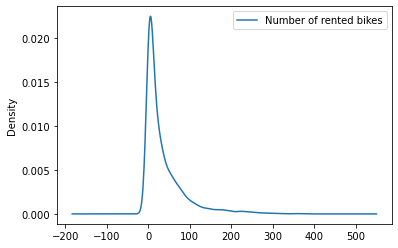

In [30]:
data.plot(x='datetime',y='Number of rented bikes',kind='kde')

In [31]:
df1_seasons = pd.DataFrame(data.groupby('season').sum()['Number of rented bikes'].sort_values(ascending=False))
df1_seasons.style.background_gradient(cmap=sns.light_palette('yellow',as_cmap=True))

,Number of rented bikes
season,
3,142718
2,129672
4,78140
1,41605


Text(0.5, 1.0, 'Number of rented bike per season')

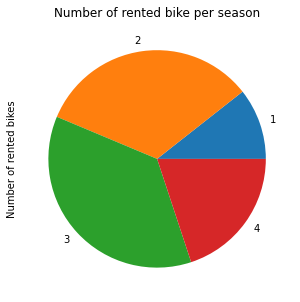

In [32]:
plt.figure(figsize=(5,5))
data.groupby('season').sum()['Number of rented bikes'].plot.pie()
plt.title("Number of rented bike per season")

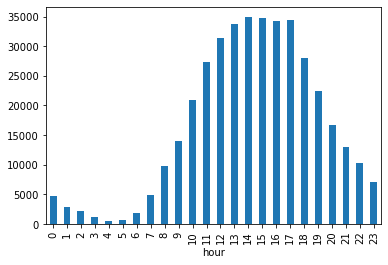

In [33]:
data.groupby('hour').sum()['Number of rented bikes'].plot.bar()

In [34]:
df1_dayOfWeek = pd.DataFrame(data.groupby('dayofweek').sum()['Number of rented bikes'].sort_values(ascending=False))
df1_dayOfWeek.style.background_gradient(cmap=sns.light_palette('yellow',as_cmap=True))

,Number of rented bikes
dayofweek,
5,100782
6,90084
4,47402
0,46288
3,37283
1,35365
2,34931


Days are encoded 0 as Mondays and 6 as Sundays



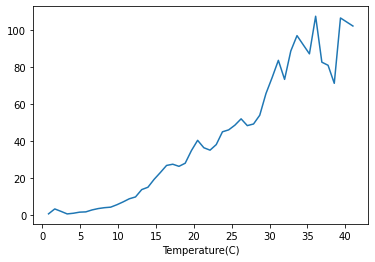

In [35]:
data.groupby('Temperature(C)').mean()['Number of rented bikes'].plot.line()

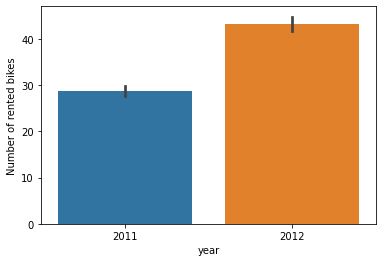

In [36]:
#plt.figure(figsize=(14,14))
sns.barplot(data=data, x='year', y=data['Number of rented bikes']);

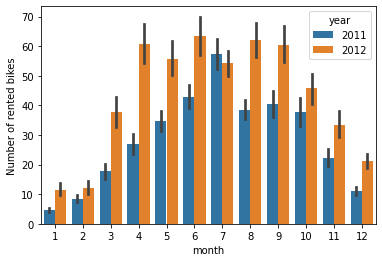

In [37]:
sns.barplot(data=data, x='month', y=data['Number of rented bikes'], hue='year')

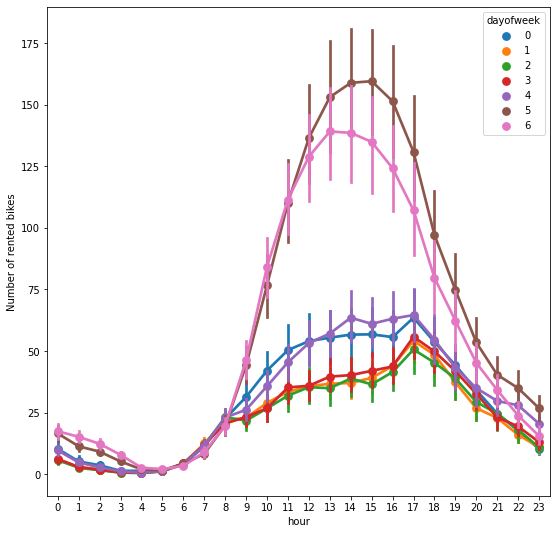

In [75]:
plt.figure(figsize=(9,9))
sns.pointplot(data=data, x='hour', y=data['Number of rented bikes'], hue='dayofweek');


In [40]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather',
       'Temperature(C)', 'Dew Temperature(C)', 'humidity(%)',
       'Wind Speed(m/s)', 'Number of rented bikes', 'registered', 'count',
       'month', 'hour', 'weekday', 'day', 'year', 'dayofweek', 'month_start'],
      dtype='object')

In [41]:
data["humidity(%)"].value_counts().sort_index()

0       22
8        1
10       1
12       1
13       1
      ... 
93     205
94     324
96       1
97       1
100    148
Name: humidity(%), Length: 89, dtype: int64

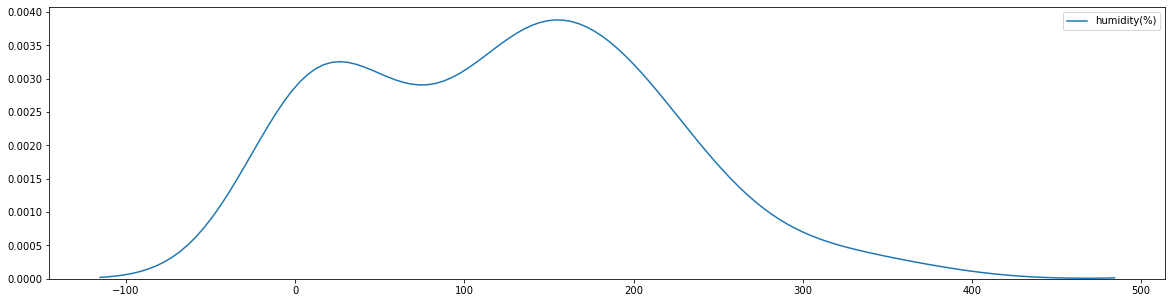

In [43]:
plt.figure(figsize=(20,5))
sns.kdeplot(data["humidity(%)"].value_counts().sort_index())

In [45]:
train.drop(['datetime','casual','registered','year'],axis=1,inplace=True)

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for c in train.columns:
    if train[c].dtype == 'object':
        train[c] = le.fit_transform(train[c])

In [47]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,hour,weekday,day,dayofweek,month_start
0,1,0,0,1,9.84,14.395,81,0.0,16,1,0,5,1,5,True
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,5,1,5,True
2,1,0,0,1,9.02,13.635,80,0.0,32,1,2,5,1,5,True
3,1,0,0,1,9.84,14.395,75,0.0,13,1,3,5,1,5,True
4,1,0,0,1,9.84,14.395,75,0.0,1,1,4,5,1,5,True


In [49]:
X = train.drop('count',axis=1)
y = train['count']

In [50]:
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2, random_state=42)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((8708, 14), (8708,), (2178, 14), (2178,))

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train=scaler.fit_transform(X_train)
X_val=scaler.fit_transform(X_val)
X_train=pd.DataFrame(X_train)
X_val=pd.DataFrame(X_val) 
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.666667,0.0,1.0,0.000000,0.673469,0.694932,0.83,0.105325,0.545455,0.217391,0.333333,0.277778,0.333333,0.0
1,0.666667,0.0,0.0,0.000000,0.897959,0.898311,0.39,0.350888,0.636364,0.695652,0.833333,0.166667,0.833333,0.0
2,0.666667,0.0,1.0,0.000000,0.795918,0.779617,0.41,0.298225,0.545455,0.652174,0.333333,0.555556,0.333333,0.0
3,0.333333,0.0,0.0,0.333333,0.346939,0.389753,0.93,0.122840,0.272727,0.173913,1.000000,0.500000,1.000000,0.0
4,1.000000,0.0,0.0,0.000000,0.306122,0.321960,0.45,0.298225,0.909091,0.434783,0.833333,1.000000,0.833333,0.0


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Define a list of regression models to train
models = [
    LinearRegression(),
    RandomForestRegressor(),
    XGBRegressor()
]

# Train and evaluate each model in a loop
for model in models:
    model_name = model.__class__.__name__
    print("Training model:", model_name)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Evaluate the model using mean squared error
    mse = mean_squared_error(y_val, y_pred)
    rmse=np.sqrt(mse)
    print("root mean squared error for ",model_name,":",rmse)


Training model: LinearRegression
root mean squared error for  LinearRegression : 147.13815467083367
Training model: RandomForestRegressor
root mean squared error for  RandomForestRegressor : 66.14350821522432
Training model: XGBRegressor
root mean squared error for  XGBRegressor : 65.02987529284


### Since XGboost Regressor gives the best rmse score so move on to tuning it.

In [57]:
xgb_reg=XGBRegressor()
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [58]:
# Performing RandomizedSearchCV for hyperparameter tuning
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5
param_comb = 100

random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=folds, verbose=3, random_state=42)

# Fitting on the train set
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 5],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 10, 12],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 200, 500, 750],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=3)

In [59]:
# Printing the best score that we can get using the parameters
print('We can get score of :',random_search.best_score_,' using',random_search.best_params_)

We can get score of : 0.9099637493068711  using {'subsample': 0.8, 'n_estimators': 750, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [60]:
# Creating XGBRegression model with the select hyperparameters
xgb_reg_hpt = XGBRegressor(subsample=0.8, n_estimators=750, min_child_weight=10,max_depth=10,
                               learning_rate=0.1, gamma=0.5, colsample_bytree=0.8, n_jobs = -1)


In [62]:
xgb_reg_hpt.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=750,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [63]:
# Predicting on the validation set
y_pred_test_hpt = xgb_reg_hpt.predict(X_val)

# Calculating R2 score on test set
r2score = round(r2_score(y_pred_test_hpt,y_val),2)*100

# Printing the R2 score on test dataset
print("R2 score on validation Data is : ",r2score)

R2 score on validation Data is :  87.0


In [64]:
# Calculating Mean Sqaured Error & Root Mean Squared Error of the test set
mse = mean_squared_error(y_val, y_pred_test_hpt)
rmse = round(math.sqrt(mse),2)
print(rmse)

60.73


In [72]:
# Calculating R2 score
y_train_pred = xgb_reg_hpt.predict(X_train)
y_test_pred = xgb_reg_hpt.predict(X_val)

r2_train_lr = r2_score(y_train, y_train_pred)
print("R2 score on Training data : ",round(r2_train_lr,2)*100)

r2_test_lr = r2_score(y_val, y_test_pred)
print("R2 score on Test data : ",round(r2_test_lr,2)*100)

R2 score on Training data :  100.0
R2 score on Test data :  89.0


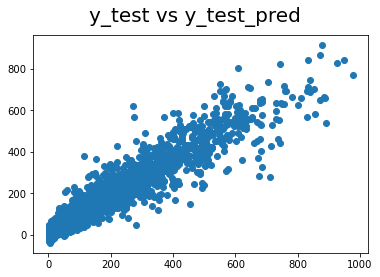

In [73]:
# Plotting a scatter plot of the actual and predicted values of the test set
fig = plt.figure()
fig.suptitle('y_test vs y_test_pred',fontsize=20)
plt.scatter(y_val,y_test_pred)